In [1]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import polymer

from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler

from polysaccharide.molutils.rdmol import rdkdraw

from polysaccharide.polymer.representation import Polymer
from polysaccharide.polymer.management import PolymerManager
from polysaccharide.polymer.filtering import has_sims, is_solvated, is_unsolvated, is_charged
from polysaccharide.polymer import building, monomer

from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    format=logutils.LOG_FORMATTER._fmt,
    datefmt=logutils.LOG_FORMATTER.datefmt,
    force=True
)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
from polysaccharide import resources
from polysaccharide.resources import AVAIL_RESOURCES

RESOURCE_PATH = resources.RESOURCE_PATH
SIM_PARAM_PATH = impres.files(resources.sim_templates)
CHG_PARAM_PATH = impres.files(resources.chg_templates)
INP_PARAM_PATH = impres.files(resources.inp_templates)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

## Collating shape property data from simulation and Colina paper

In [78]:
# Defining Paths and PolymerManagers

## Data file directories
data_dir = Path('data_for_paper')

colina_dir = data_dir / 'colina_data'

openff_dir = data_dir / 'openff_data'
openff_dir.mkdir(exist_ok=True)

combined_dir = data_dir / 'combined_data'
combined_dir.mkdir(exist_ok=True)

## Plot directories
fig_dir  = Path('figures_for_paper')

plot_prop_dir = fig_dir / 'property_plots'
plot_prop_dir.mkdir(exist_ok=True)

## Polymer collections
COLL_PATH = Path('Collections')

src_mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers')
conf_mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
equil_mgr = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')

In [79]:
# Producing atom and monomer number counts
size_dict = {}
for mol_name, polymer in src_mgr.polymers.items():
    SMARTS = polymer.monomer_info.SMARTS
    DOP = monomer.estimate_DOP_upper(SMARTS, min_chain_len=polymer.n_atoms)
    N = monomer.estimate_chain_len(SMARTS, DOP=DOP)
    assert(N == polymer.n_atoms)

    size_dict[mol_name] = {
        'N_atoms' : N,
        'N_monomers' : DOP
    }
size_table = pd.DataFrame.from_dict(size_dict, orient='index')

In [80]:
# Extracting high-dimensional data "cube" of observable averages for all replicates
full_data = defaultdict(lambda : defaultdict(lambda : defaultdict(list)))
for mol_name, sim_dirs_list in equil_mgr.all_completed_sims.items():
    polymer = equil_mgr.polymers[mol_name]
    for sim_dir in sim_dirs_list:
        sim_paths, sim_params = polymer.load_sim_paths_and_params(sim_dir)

        time_data = pd.read_csv(sim_paths.time_data)
        x_data, y_data = trajectory.props_to_plot_data(time_data)
        for prop_name, time_series in y_data.items():
            full_data[polymer.base_mol_name][sim_params.charge_method][prop_name].append(time_series.mean())

In [88]:
# Computing means and uncertainties and collating into dataframes 
dframe_fns = {
    'observables'   : np.mean,
    'uncertainties' : lambda arr : np.std(arr, ddof=1) # inlude Bessel's correction in uncertainty calculation
}

for mol_name, mol_dict in full_data.items():
    dframe = pd.DataFrame.from_dict({
        f'Sage 2.0.0 - {fw_desc}' : {
            (outname, prop_name) : dframe_fn(prop_data)
                for outname, dframe_fn in dframe_fns.items()
                    for prop_name, prop_data in data_dict.items()
        }
        for fw_desc, data_dict in full_data['paam_modified'].items()
    })
    dframe.to_csv(openff_dir / f'{mol_name}.csv')

In [89]:
# Merging new dataframes with data from Colina paper
for ref_data_dir in colina_dir.iterdir():
    filename = ref_data_dir.name

    new_data = pd.read_csv(openff_dir / filename, index_col=[0, 1])
    ref_data = pd.read_csv(ref_data_dir         , index_col=[0, 1])
    data = pd.concat([new_data, ref_data], axis=1)

    data.to_csv(combined_dir / filename)

## Plotting property comparisons

In [90]:
# defining colors for MD framework (sampled from tab20)
color_set = (
    'blue',
    'orange',
    'green',
    'purple',
    'grey',
)
hues_per_color = 4
cmap = plt.get_cmap('tab20c')
cdict, carr = plotutils.label_discrete_cmap(cmap, color_set, hues_per_color)

dset_colors = {
    'Sage 2.0.0 - ABE10_averaged'   : cdict['blue0'],
    'Sage 2.0.0 - Espaloma_AM1BCC'  : cdict['blue2'],
    'CHARMM - Mulliken'             : cdict['orange0'],
    'CHARMM-c - Mulliken'             : cdict['orange2'],
    'GAFF - RESP'                   : cdict['green0'],
    'GAFF2 - RESP'                  : cdict['green2'],
    'DREIDING - RESP'               : cdict['purple0'],
}

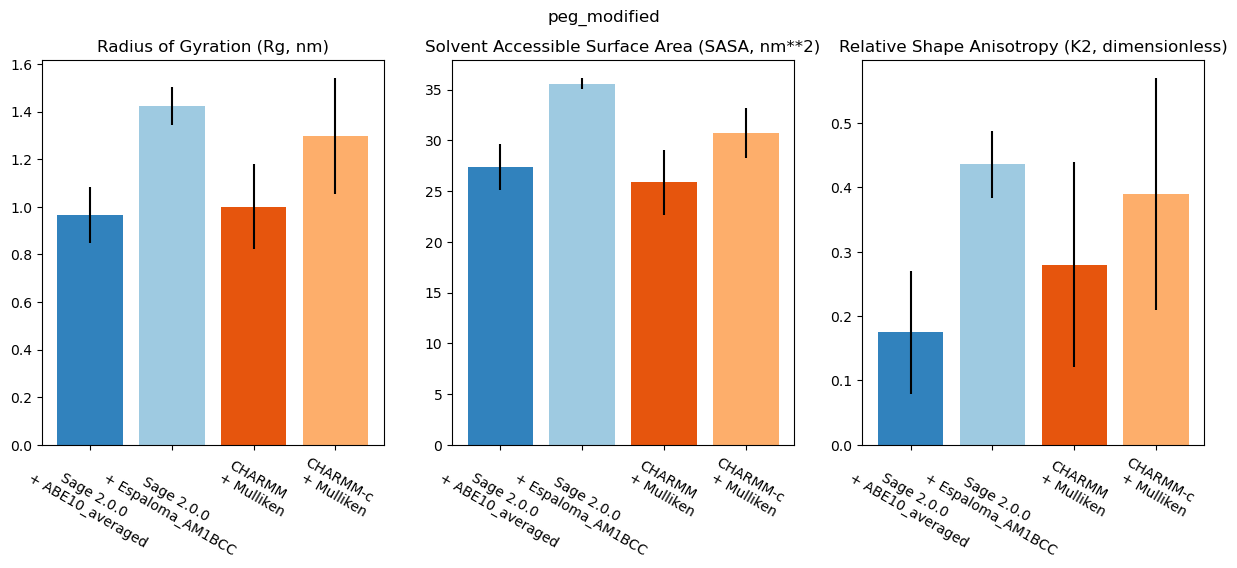

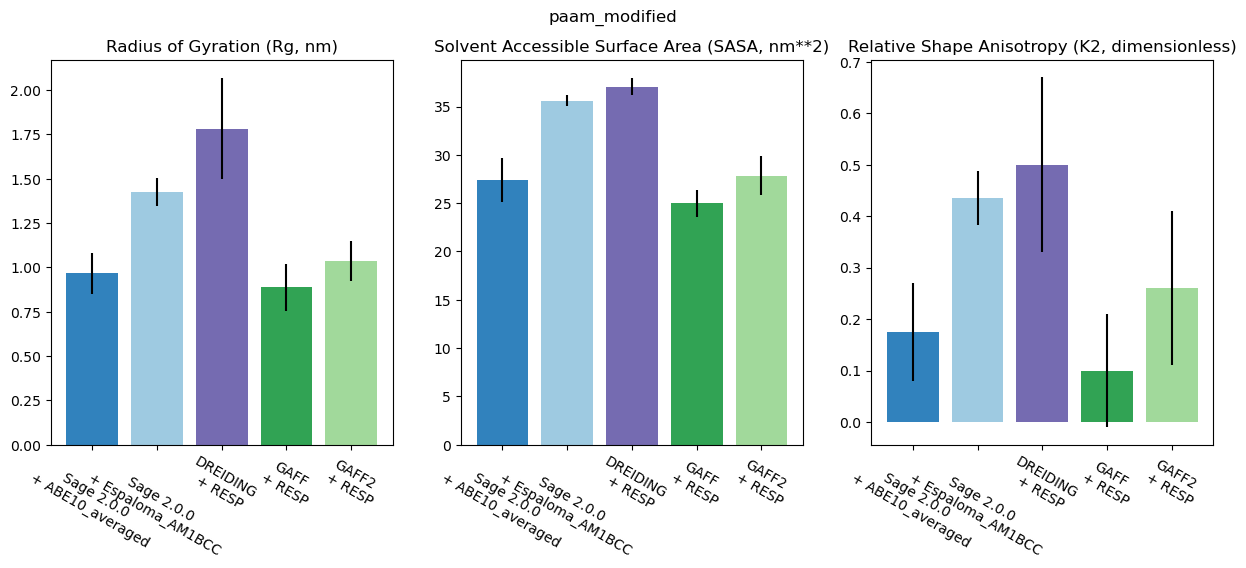

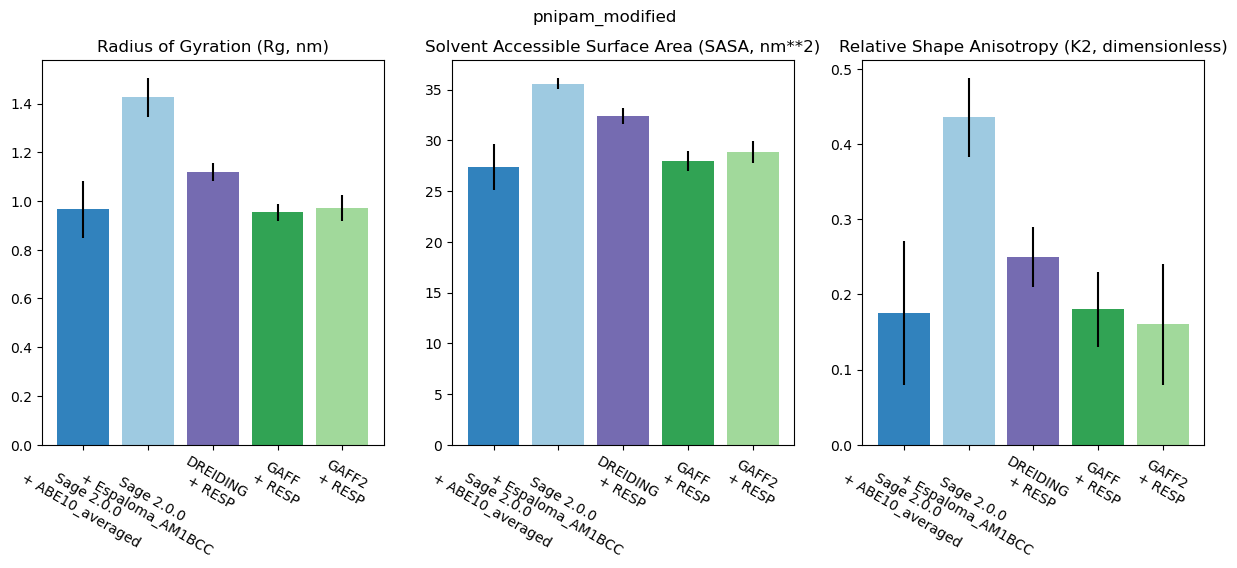

In [91]:
for mol_name in equil_mgr.unique_polymer_names:
    dframe = pd.read_csv(combined_dir / f'{mol_name}.csv', index_col=[0, 1])
    obs = dframe.loc['observables']
    std = dframe.loc['uncertainties']

    frameworks = obs.columns
    num_dsets = len(frameworks)
    num_props = len(obs.index)
    x_pos = np.arange(num_dsets)

    fig, ax = plotutils.presize_subplots(nrows=1, ncols=num_props)
    fig.suptitle(mol_name)

    for axis, (prop_name, prop_data) in zip(ax.flatten(), obs.iterrows()):
        uncert = std.loc[prop_name].to_numpy()

        axis.set_title(prop_name)
        axis.bar(x_pos, prop_data, yerr=uncert, color=[dset_colors[fr] for fr in frameworks])
        axis.set_xticks(x_pos)
        axis.set_xticklabels([fw.replace(' - ', '\n + ') for fw in obs.columns], rotation=-30)

    # fig.savefig(plot_prop_dir / f'{mol_name}_properties.png', bbox_inches='tight')

## Comparing ABE10 and Espaloma charges

In [3]:
for polymer in src_mgr.polymers_list:
    fig, ax = polymer.compare_charges('ABE10_averaged', 'Espaloma_AM1BCC', converter='CXSMARTS')

NameError: name 'src_mgr' is not defined

## Plotting replicate data

In [ ]:
chg_dict = data_agg['ABE10_averaged']
# chg_dict = data_agg['Espaloma_AM1BCC']

fig, ax = plotutils.presize_subplots(nrows=1, ncols=len(chg_dict))
for axis, (mol_name, prop_dict) in zip(ax.flatten(), chg_dict.items()):
    x_pos = np.arange(len(prop_dict))
    means, stds = [], []

    for prop_name, prop_data in prop_dict.items():
        means.append(np.mean(prop_data))
        stds.append(np.std(prop_data))

    axis.set_title(f'{mol_name} Shape Properties')
    axis.bar(x_pos, means, yerr=stds)
    axis.set_xticks(x_pos)
    axis.set_xticklabels(prop_dict.keys(), rotation=-45)

In [ ]:
chg_method = 'Espaloma_AM1BCC'
pd.DataFrame(data_agg[chg_method]['paam_modified'].items(), columns=['', chg_method])

In [ ]:
data_agg

## Prior plotting

In [ ]:
pdir = mgr.polymers['polyvinylchloride']
spath, sparam = pdir.load_sim_paths_and_params()
df = pd.read_csv(spath.state_data)

In [ ]:
mgr_equil = PolymerManager(COLL_PATH / 'water_soluble_polymers_equil')
for mol_name, polymer in mgr_equil.filtered_by(is_solvated).items():
    print(mol_name, len(polymer.completed_sims))

In [ ]:
rdf_dframe = pd.read_csv(sim_paths.spatial_data)
radii, rdfs = analysis.trajectory.rdfs_to_plot_data(rdf_dframe)
fig, ax = plotutils.plot_df_props(radii, rdfs)

In [ ]:
prop_dframe = pd.read_csv(sim_paths.time_data)
times, props = analysis.trajectory.props_to_plot_data(prop_dframe)
fig, ax = plotutils.plot_df_props(times, props)

In [ ]:
mgr_confs = PolymerManager(COLL_PATH / 'water_soluble_polymers_confs')
mol_name = 'paam_modified_conf_1_solv_water'

pdir = mgr_confs.polymers[mol_name]
sim_dir = mgr_confs.all_completed_sims[mol_name][0]
sim_paths, sim_params = pdir.load_sim_paths_and_params(sim_dir)